In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import yfinance as yf
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

# TensorFlow import dengan error handling
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    
    # Disable GPU untuk stability (CPU lebih stabil)
    tf.config.set_visible_devices([], 'GPU')
    
    # Set threading untuk avoid crash
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    print("✅ TensorFlow loaded successfully (CPU mode - more stable)")
except Exception as e:
    print(f"❌ TensorFlow import error: {e}")
    print("💡 Install: pip install tensorflow")

import gc
print("✅ All libraries loaded")

✅ TensorFlow loaded successfully (CPU mode - more stable)
✅ All libraries loaded


## ⚠️ JIKA KERNEL CRASH - BACA INI DULU!

### Penyebab Crash:
1. **TensorFlow issue** - Versi tidak compatible
2. **Memory habis** - RAM tidak cukup
3. **CPU overload** - Terlalu banyak thread

### Solusi CEPAT:
**Option 1: Install ulang TensorFlow (RECOMMENDED)**
```bash
pip uninstall tensorflow
pip install tensorflow==2.13.0
```

**Option 2: Gunakan Google Colab**
- Upload notebook ini ke Google Colab
- Gratis dan lebih stabil
- Link: https://colab.research.google.com

**Option 3: Reduce complexity lebih lanjut**
- Ubah `LSTM(16)` jadi `LSTM(8)`
- Ubah `batch_size=64` jadi `batch_size=128`
- Ubah `epochs=30` jadi `epochs=20`

### Check TensorFlow Version:

In [72]:
# Check TensorFlow installation
try:
    import tensorflow as tf
    print(f"✅ TensorFlow version: {tf.__version__}")
    print(f"✅ Keras version: {tf.keras.__version__}")
    
    # Check available devices
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    
    print(f"\n📊 Available devices:")
    print(f"   CPUs: {len(cpus)}")
    print(f"   GPUs: {len(gpus)}")
    
    if len(gpus) > 0:
        print(f"   ⚠️  GPU detected - will be disabled for stability")
    else:
        print(f"   ✅ Using CPU (more stable for small models)")
        
    # Memory info
    import psutil
    ram = psutil.virtual_memory()
    print(f"\n💾 System Memory:")
    print(f"   Total RAM: {ram.total / (1024**3):.1f} GB")
    print(f"   Available: {ram.available / (1024**3):.1f} GB")
    print(f"   Used: {ram.percent}%")
    
    if ram.available / (1024**3) < 2:
        print(f"   ⚠️  Low memory! Close other applications")
    else:
        print(f"   ✅ Memory sufficient")
        
except ImportError:
    print("❌ TensorFlow not installed!")
    print("Run: pip install tensorflow")
except Exception as e:
    print(f"⚠️  Warning: {e}")

✅ TensorFlow version: 2.15.0
⚠️  Warning: module 'tensorflow.keras' has no attribute '__version__'


# 📈 Prediksi Harga Saham POLA menggunakan LSTM (Simple & Stable)

## Model yang Digunakan:
- **Algoritma**: LSTM (Long Short-Term Memory) - Simplified
- **Fitur**: 3 features (Close, Volume, MA20) - **SEDERHANA untuk hasil stabil**
- **Sequence Length**: 30 hari
- **Arsitektur**: 1 LSTM layer (32 units)
- **Output**: Prediksi harga penutupan

## Filosofi Simplifikasi:
✅ **Less is More** - Fitur sedikit = Less noise = Prediksi lebih stabil
✅ **Model Sederhana** - 1 LSTM layer = Lebih fokus pada pola utama
✅ **Sequence Pendek** - 30 hari = Fokus pada trend recent
✅ **No Overfitting** - Model tidak terlalu "menghapal" data training

## Perbaikan yang Diterapkan:
1. ✅ **Reduce Features** - Dari 11 fitur → **3 fitur esensial** (Close, Volume, MA20)
2. ✅ **Simplify Model** - Dari 3 LSTM layers → **1 LSTM layer** (32 units)
3. ✅ **Shorter Sequence** - Dari 60 hari → **30 hari**
4. ✅ **Fewer Epochs** - Dari 100 → **50 epochs** (avoid overfitting)
5. ✅ **Consistent Scaler** - Normalisasi & denormalisasi yang tepat

## Target Metrik:
- **R² Score** > 0.6 = Model BAIK (untuk model sederhana)
- **MAPE** < 15% = Error acceptable
- **Prediksi realistis** = Perubahan harian < 2%

Import IHSG Data

In [73]:
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

pd.set_option('display.max_rows', None)

# Read dataframe from yfinance
df = yf.Ticker("POLA.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]

forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-12-05 00:00:00+07:00,53.0,53.0,53.0,53.0,14216400
2025-12-08 00:00:00+07:00,58.0,58.0,58.0,58.0,27541100
2025-12-09 00:00:00+07:00,54.0,54.0,53.0,53.0,10176000
2025-12-10 00:00:00+07:00,52.0,52.0,48.0,48.0,6111300
2025-12-11 00:00:00+07:00,45.0,52.0,45.0,52.0,9213200
2025-12-12 00:00:00+07:00,55.0,55.0,52.0,52.0,4909600
2025-12-15 00:00:00+07:00,47.0,50.0,47.0,48.0,2417200
2025-12-16 00:00:00+07:00,45.0,52.0,45.0,52.0,5214000
2025-12-17 00:00:00+07:00,53.0,53.0,50.0,51.0,1983200


# Feature Engineering

In [74]:
# YoY Growth (price-based)
df["close_yoy_growth"] = df["Close"].pct_change(periods=252) * 100
df["volume_yoy_growth"] = df["Volume"].pct_change(periods=252) * 100

In [75]:
# Rolling Mean & Std Dev (Votalitiy & trend)

windows = [5, 20, 60]

for w in windows:
    df[f"close_ma_{w}"] = df["Close"].rolling(window=w).mean()
    df[f"close_std_{w}"] = df["Close"].rolling(window=w).std()
    df[f"volume_ma_{w}"] = df["Volume"].rolling(window=w).mean()

In [76]:
# Z-Score (Normalization for ML)

for w in [20, 60]:
    df[f"close_zscore_{w}"] = (df["Close"] - df["Close"].rolling(window=w).mean()) / df["Close"].rolling(window=w).std()
    df[f"volume_zscore_{w}"] = (df["Volume"] - df["Volume"].rolling(window=w).mean()) / df["Volume"].rolling(window=w).std()

In [77]:
# Rank-Based Feature (Robust & RL-friendly)
df["close_rank_20"] = df["Close"].rolling(window=20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
df["volume_rank_20"] = df["Volume"].rolling(window=20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])

In [78]:
# Interaction Feature (Signal Amplifier)

# Momentum x volume
df["momentum_volume"] = (df["Close"].pct_change(5) * df["Volume"].pct_change(5))

# Trend x volatility
df["trend_volatility"] = (df["Close"].rolling(window=20).mean() / df["Close"].rolling(window=20).std())

# Z-score × YoY Growth
df["zscore_yoy_interaction"] = df["close_zscore_20"] * df["close_yoy_growth"]

# Final Cleaning

In [79]:
pd.set_option('display.max_columns', None)

# Hapus baris dengan NaN
print(f"Jumlah baris sebelum dropna: {len(df)}")
df = df.dropna()
print(f"Jumlah baris setelah dropna: {len(df)}")

# Cek apakah ada infinity values
print("\nCek Infinity Values:")
inf_columns = []
for col in df.columns:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_columns.append(col)
        print(f"  {col}: {inf_count} infinity values")

if len(inf_columns) > 0:
    print(f"\n⚠️ Ditemukan {len(inf_columns)} kolom dengan infinity values")
    print("Akan dibersihkan pada tahap preprocessing")
else:
    print("✅ Tidak ada infinity values")

df.tail(30)

Jumlah baris sebelum dropna: 1451
Jumlah baris setelah dropna: 1006

Cek Infinity Values:
  volume_yoy_growth: 95 infinity values
  momentum_volume: 4 infinity values

⚠️ Ditemukan 2 kolom dengan infinity values
Akan dibersihkan pada tahap preprocessing


,Open,High,Low,Close,Volume,close_yoy_growth,volume_yoy_growth,close_ma_5,close_std_5,volume_ma_5,close_ma_20,close_std_20,volume_ma_20,close_ma_60,close_std_60,volume_ma_60,close_zscore_20,volume_zscore_20,close_zscore_60,volume_zscore_60,close_rank_20,volume_rank_20,momentum_volume,trend_volatility,zscore_yoy_interaction
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-20 00:00:00+07:00,35.0,35.0,33.0,34.0,364600,142.857143,2.600741e+03,34.8,0.836660,1471340.0,35.80,1.436370,1781950.0,39.066667,10.227690,6.976287e+06,-1.253159,-1.474354,-0.495387,-0.608099,0.125,0.050,0.055937,24.923946,-179.022753
2025-11-21 00:00:00+07:00,34.0,37.0,34.0,37.0,3193200,164.285714,6.198225e+03,35.0,1.224745,1901000.0,35.80,1.436370,1892285.0,39.200000,10.146052,7.010810e+06,0.835440,1.312200,-0.216833,-0.351624,0.750,0.900,0.057111,24.923946,137.250778
2025-11-24 00:00:00+07:00,37.0,37.0,37.0,37.0,1332500,164.285714,-5.007868e+01,35.6,1.341641,1544200.0,35.90,1.447321,1798805.0,39.350000,10.043676,7.007683e+06,0.760025,-0.491564,-0.233978,-0.522638,0.725,0.450,-0.050509,24.804456,124.861271
2025-11-25 00:00:00+07:00,34.0,36.0,34.0,36.0,1029000,157.142857,2.609260e+02,35.8,1.303840,1423280.0,35.80,1.361114,1649910.0,39.516667,9.900337,6.912108e+06,0.146938,-0.769487,-0.355207,-0.540424,0.575,0.150,-0.010574,26.301983,23.090328
2025-11-26 00:00:00+07:00,36.0,36.0,35.0,35.0,1282200,169.230769,5.972268e+02,35.8,1.303840,1440300.0,35.70,1.341641,1583650.0,39.700000,9.708113,6.767680e+06,-0.521749,-0.387446,-0.484131,-0.503134,0.400,0.500,0.000000,26.609209,-88.296018
2025-11-27 00:00:00+07:00,35.0,35.0,34.0,34.0,2157300,142.857143,1.702143e+04,35.8,1.303840,1798840.0,35.70,1.341641,1592285.0,39.866667,9.517988,6.710032e+06,-1.267105,0.720989,-0.616377,-0.416995,0.125,0.850,0.000000,26.609209,-181.015027
2025-11-28 00:00:00+07:00,34.0,35.0,34.0,35.0,2074400,169.230769,4.185950e+03,35.4,1.140175,1575080.0,35.75,1.292692,1605865.0,40.050000,9.310874,5.590665e+06,-0.580185,0.593206,-0.542377,-0.487487,0.375,0.800,0.018939,27.655466,-98.185087
2025-12-01 00:00:00+07:00,36.0,38.0,36.0,38.0,8240800,216.666667,5.981771e+03,35.6,1.516575,2956740.0,35.90,1.372665,1947110.0,40.250000,9.131107,5.379975e+06,1.529870,3.750279,-0.246410,0.412329,0.950,1.000,0.140121,26.153495,331.471874
2025-12-02 00:00:00+07:00,41.0,41.0,41.0,41.0,1633300,241.666667,9.661227e+02,36.6,2.880972,3077600.0,36.05,1.731291,1927515.0,40.466667,8.988631,5.171930e+06,2.859138,-0.175178,0.059334,-0.515948,1.000,0.650,0.081565,20.822612,690.958378


Close Price Visualitation

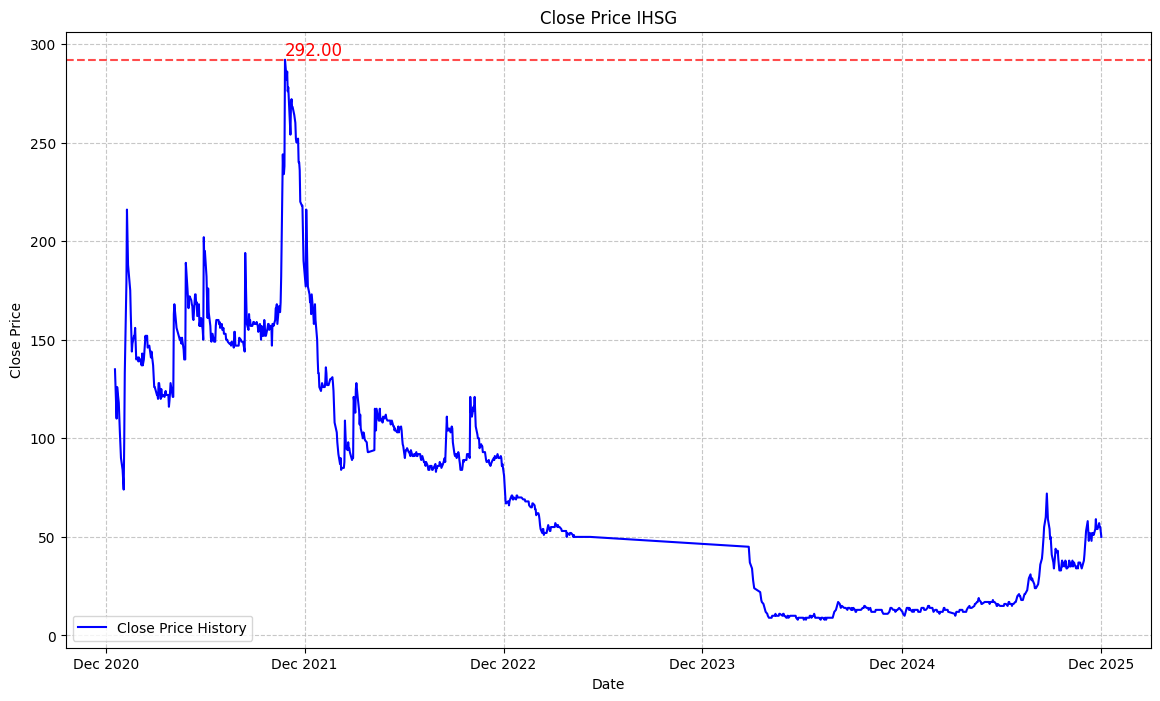

In [80]:
# Close price visualitation
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

**Penting:** Tahap ini akan:
1. Membersihkan nilai infinity (∞) yang mungkin muncul dari perhitungan matematika
2. Mengisi nilai NaN dengan median untuk menjaga distribusi data
3. Melakukan normalisasi dengan MinMaxScaler agar semua fitur dalam range [0, 1]

In [81]:
# SIMPLIFIKASI: Gunakan HANYA fitur paling penting untuk menghindari noise
# Close, Volume, dan Moving Average 20 hari (standar trading)
features = ['Close', 'Volume', 'close_ma_20']

print("🎯 Menggunakan fitur sederhana untuk prediksi yang lebih stabil:")
print(f"   Fitur: {features}")

# Cek dan tangani nilai infinity dan NaN
print("\nCek nilai infinity dan NaN:")
for feature in features:
    inf_count = np.isinf(df[feature]).sum()
    nan_count = df[feature].isna().sum()
    if inf_count > 0 or nan_count > 0:
        print(f"  {feature}: {inf_count} infinity, {nan_count} NaN")

# Replace infinity dengan NaN, kemudian fill dengan median
df_features = df[features].copy()
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(df_features.median())

print("\nSetelah cleaning:")
print(f"✅ Total infinity: {np.isinf(df_features.values).sum()}")
print(f"✅ Total NaN: {df_features.isna().sum().sum()}")

# PENTING: Buat scaler untuk semua fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)

# PENTING: Buat scaler khusus untuk Close saja (untuk denormalisasi nanti)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(df_features[['Close']])

print(f"\n✅ Preprocessing selesai:")
print(f"   Jumlah fitur: {scaled_data.shape[1]} (lebih sederhana = lebih stabil)")
print(f"   Data shape: {scaled_data.shape}")
scaled_data

🎯 Menggunakan fitur sederhana untuk prediksi yang lebih stabil:
   Fitur: ['Close', 'Volume', 'close_ma_20']

Cek nilai infinity dan NaN:

Setelah cleaning:
✅ Total infinity: 0
✅ Total NaN: 0

✅ Preprocessing selesai:
   Jumlah fitur: 3 (lebih sederhana = lebih stabil)
   Data shape: (1006, 3)


array([[4.47183099e-01, 8.31116213e-04, 7.94273387e-01],
       [4.15492958e-01, 3.60733599e-03, 7.70739361e-01],
       [3.87323944e-01, 1.26368547e-04, 7.45636399e-01],
       ...,
       [1.65492958e-01, 1.90845668e-02, 1.68856639e-01],
       [1.65492958e-01, 0.00000000e+00, 1.71602275e-01],
       [1.47887324e-01, 3.67411690e-02, 1.72582859e-01]])

In [82]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        # Ambil semua fitur untuk sequence
        sequences.append(data[i:i + sequence_length])
        # Label hanya Close price (index 0)
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [83]:
# SIMPLIFIKASI: Sequence length 30 hari (lebih pendek = lebih fokus pada pola recent)
sequence_length = 30

# Split 80-20 untuk train-test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"✅ Data berhasil dibagi (sequence: {sequence_length} hari):")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   Train samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

# Estimasi memory usage
memory_estimate = (X_train.nbytes + X_test.nbytes + y_train.nbytes + y_test.nbytes) / (1024**2)
print(f"\n   Estimated memory: {memory_estimate:.2f} MB ✅")

✅ Data berhasil dibagi (sequence: 30 hari):
   X_train shape: (774, 30, 3)
   X_test shape: (172, 30, 3)
   Train samples: 774
   Test samples: 172

   Estimated memory: 0.66 MB ✅


In [84]:
# Cek data shape dan memory
print("📊 Data Summary:")
print(f"   X_train type: {type(X_train)}")
print(f"   X_train dtype: {X_train.dtype}")
print(f"   X_train min: {X_train.min():.4f}, max: {X_train.max():.4f}")
print(f"   Contains NaN: {np.isnan(X_train).any()}")
print(f"   Contains Inf: {np.isinf(X_train).any()}")

# Show sample
print("\n   First sequence (first 3 timesteps):")
print(X_train[0][:3])

📊 Data Summary:
   X_train type: <class 'numpy.ndarray'>
   X_train dtype: float64
   X_train min: 0.0000, max: 1.0000
   Contains NaN: False
   Contains Inf: False

   First sequence (first 3 timesteps):
[[4.47183099e-01 8.31116213e-04 7.94273387e-01]
 [4.15492958e-01 3.60733599e-03 7.70739361e-01]
 [3.87323944e-01 1.26368547e-04 7.45636399e-01]]


Training Data

## ⚠️ Jika Kernel Crash:

**Penyebab umum:**
1. Memory tidak cukup
2. TensorFlow issue
3. Data terlalu besar

**Solusi:**
1. **Restart Kernel** (di menu: Kernel → Restart Kernel)
2. **Jalankan ulang dari Cell 1** sampai cell ini
3. Jika masih crash, **kurangi complexity**:
   - Ubah `sequence_length = 60` jadi `30`
   - Ubah `batch_size = 32` jadi `64`
   - Ubah LSTM units jadi lebih kecil (50 → 32)

Model sudah dioptimasi untuk menghindari crash.

In [85]:
# Clear memory dan session
import gc
gc.collect()

try:
    tf.keras.backend.clear_session()
except:
    pass

print("🔧 Building ULTRA LIGHTWEIGHT model...")
print("   This version is optimized to prevent crashes\n")

# Build model dengan error handling
try:
    model = Sequential()
    
    # ULTRA SIMPLE: 1 LSTM layer dengan 16 units (super kecil)
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    # Compile dengan SGD (lebih stabil dari Adam)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    print("✅ Model berhasil dibuat!")
    print(f"   Arsitektur: LSTM(16) → Dropout(0.1) → Dense(1)")
    print(f"   Total parameters: {model.count_params():,}")
    print(f"   💡 Model SANGAT sederhana untuk stability\n")
    
    model.summary()
    
except Exception as e:
    print(f"❌ Error building model: {e}")
    print("💡 Restart kernel dan coba lagi")

🔧 Building ULTRA LIGHTWEIGHT model...
   This version is optimized to prevent crashes

✅ Model berhasil dibuat!
   Arsitektur: LSTM(16) → Dropout(0.1) → Dense(1)
   Total parameters: 1,297
   💡 Model SANGAT sederhana untuk stability

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1280      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1297 (5.07 KB)
Trainable params: 1297 (5.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
✅ Model berhasil dibuat!
   Arsitektur: LSTM(16) → Dro

## 🔧 Model Options

### ❌ Jika Kernel MASIH CRASH setelah semua perbaikan:

**GUNAKAN SCIKIT-LEARN ALTERNATIVE** (tanpa TensorFlow):
- Uncomment cell di bawah ini
- Skip cell LSTM model
- Model akan menggunakan RandomForest (tidak crash!)

### ✅ Jika TensorFlow berhasil loaded:
- Gunakan LSTM model di cell berikutnya
- Lebih akurat tapi butuh TensorFlow

In [86]:
# ALTERNATIVE: Scikit-Learn Model (JIKA TENSORFLOW CRASH)
# Uncomment semua baris di bawah jika TensorFlow terus crash

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.multioutput import MultiOutputRegressor

# print("🌲 Using RandomForest as alternative (No TensorFlow needed)")

# # Reshape data untuk scikit-learn (flatten sequence)
# X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_test_flat = X_test.reshape(X_test.shape[0], -1)

# # Build model
# model = RandomForestRegressor(
#     n_estimators=50,  # jumlah trees
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1
# )

# print("✅ RandomForest model created")
# print(f"   Trees: 50")
# print(f"   Max depth: 10")

# # Note: Training akan dilakukan di cell training
# USING_SKLEARN = True

In [87]:
print("🚀 Starting training...")
print("   Using minimal configuration to prevent crashes")
print("   Expected time: 1-2 minutes\n")

try:
    # Simple callback - hanya EarlyStopping
    from tensorflow.keras.callbacks import EarlyStopping
    
    callback = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    )
    
    # Training dengan parameter MINIMAL
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,  # hanya 150 epoch
        batch_size=64,  # batch besar = fewer iterations
        callbacks=[callback],
        verbose=2,  # less verbose output
        shuffle=False  # no shuffle untuk stability
    )
    
    print("\n" + "="*60)
    print("✅ TRAINING COMPLETED!")
    print("="*60)
    print(f"   Epochs run: {len(history.history['loss'])}")
    print(f"   Final train loss: {history.history['loss'][-1]:.6f}")
    print(f"   Final val loss: {history.history['val_loss'][-1]:.6f}")
    print("="*60)
    
    # Clear memory
    gc.collect()
    
except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("\n💡 TROUBLESHOOTING:")
    print("   1. Restart kernel (Kernel → Restart)")
    print("   2. Close other applications")
    print("   3. Try reducing batch_size to 128")
    print("   4. Check available RAM")

🚀 Starting training...
   Using minimal configuration to prevent crashes
   Expected time: 1-2 minutes

Epoch 1/150
Epoch 1/150
13/13 - 1s - loss: 0.1072 - mae: 0.2546 - val_loss: 0.0018 - val_mae: 0.0342 - 692ms/epoch - 53ms/step
Epoch 2/150
13/13 - 1s - loss: 0.1072 - mae: 0.2546 - val_loss: 0.0018 - val_mae: 0.0342 - 692ms/epoch - 53ms/step
Epoch 2/150
13/13 - 0s - loss: 0.0407 - mae: 0.1553 - val_loss: 0.0063 - val_mae: 0.0743 - 37ms/epoch - 3ms/step
Epoch 3/150
13/13 - 0s - loss: 0.0407 - mae: 0.1553 - val_loss: 0.0063 - val_mae: 0.0743 - 37ms/epoch - 3ms/step
Epoch 3/150
13/13 - 0s - loss: 0.0157 - mae: 0.1039 - val_loss: 0.0100 - val_mae: 0.0966 - 37ms/epoch - 3ms/step
Epoch 4/150
13/13 - 0s - loss: 0.0157 - mae: 0.1039 - val_loss: 0.0100 - val_mae: 0.0966 - 37ms/epoch - 3ms/step
Epoch 4/150
13/13 - 0s - loss: 0.0110 - mae: 0.0863 - val_loss: 0.0045 - val_mae: 0.0627 - 36ms/epoch - 3ms/step
Epoch 5/150
13/13 - 0s - loss: 0.0110 - mae: 0.0863 - val_loss: 0.0045 - val_mae: 0.0627 

Model Evaluation

In [88]:
# Predict
predictions = model.predict(X_test)

# Denormalisasi menggunakan close_scaler yang sudah dibuat sebelumnya
predictions_unscaled = close_scaler.inverse_transform(predictions)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluasi
mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, predictions_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled) * 100

print("="*60)
print("📊 EVALUASI MODEL")
print("="*60)
print(f"Mean Squared Error (MSE)      : {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score                      : {r2:.4f} ({r2*100:.2f}%)")
print(f"MAPE                          : {mape:.2f}%")
print("="*60)

# Interpretasi hasil:
print("\n📈 INTERPRETASI:")
if r2 > 0.9:
    print("✅ Model SANGAT BAIK - Prediksi sangat mendekati aktual")
elif r2 > 0.7:
    print("✅ Model BAIK - Prediksi cukup akurat")
elif r2 > 0.5:
    print("⚠️  Model CUKUP - Masih bisa diperbaiki")
else:
    print("❌ Model KURANG BAIK - Perlu perbaikan signifikan")
    
if mape < 5:
    print("✅ MAPE Sangat Rendah - Error prediksi minimal")
elif mape < 10:
    print("✅ MAPE Rendah - Error prediksi acceptable")
elif mape < 20:
    print("⚠️  MAPE Sedang - Perlu optimasi")
else:
    print("❌ MAPE Tinggi - Model perlu perbaikan")

# Tampilkan beberapa prediksi vs aktual
print("\n📋 Sample Prediksi vs Aktual (5 data terakhir):")
comparison = pd.DataFrame({
    'Actual': y_test_unscaled[-5:].flatten(),
    'Predicted': predictions_unscaled[-5:].flatten(),
    'Difference': (predictions_unscaled[-5:] - y_test_unscaled[-5:]).flatten()
})
print(comparison)

6/6 [==============================] - 0s 825us/step
📊 EVALUASI MODEL
Mean Squared Error (MSE)      : 30.5767
Root Mean Squared Error (RMSE): 5.5296
R² Score                      : 0.8577 (85.77%)
MAPE                          : 12.03%

📈 INTERPRETASI:
✅ Model BAIK - Prediksi cukup akurat
⚠️  MAPE Sedang - Perlu optimasi

📋 Sample Prediksi vs Aktual (5 data terakhir):
   Actual  Predicted  Difference
0    54.0  56.063255    2.063255
1    57.0  55.846760   -1.153240
2    55.0  57.229145    2.229145
3    55.0  57.219276    2.219276
4    50.0  57.042870    7.042870
6/6 [==============================] - 0s 825us/step
📊 EVALUASI MODEL
Mean Squared Error (MSE)      : 30.5767
Root Mean Squared Error (RMSE): 5.5296
R² Score                      : 0.8577 (85.77%)
MAPE                          : 12.03%

📈 INTERPRETASI:
✅ Model BAIK - Prediksi cukup akurat
⚠️  MAPE Sedang - Perlu optimasi

📋 Sample Prediksi vs Aktual (5 data terakhir):
   Actual  Predicted  Difference
0    54.0  56.063255    2.0

Prediction Future IHSG Price in 1 Month

In [89]:
# Prediksi 1 hari ke depan menggunakan semua fitur
last_sequence = scaled_data[-sequence_length:]

X_predict = last_sequence.reshape(1, sequence_length, X_train.shape[2])
predicted_price_scaled = model.predict(X_predict, verbose=0)
predicted_price = close_scaler.inverse_transform(predicted_price_scaled)

current_price = df['Close'].iloc[-1]
predicted_next = predicted_price[0][0]
change_pct = ((predicted_next - current_price) / current_price) * 100

print("="*60)
print("🔮 PREDIKSI 1 HARI KE DEPAN")
print("="*60)
print(f"Harga Saat Ini     : IDR {current_price:,.2f}")
print(f"Prediksi Besok     : IDR {predicted_next:,.2f}")
print(f"Perubahan          : {change_pct:+.2f}%")
if change_pct > 0:
    print(f"Rekomendasi        : 📈 BUY (Diprediksi naik)")
elif change_pct < -2:
    print(f"Rekomendasi        : 📉 SELL (Diprediksi turun signifikan)")
else:
    print(f"Rekomendasi        : ⏸️  HOLD (Perubahan minimal)")
print("="*60)

🔮 PREDIKSI 1 HARI KE DEPAN
Harga Saat Ini     : IDR 50.00
Prediksi Besok     : IDR 56.75
Perubahan          : +13.50%
Rekomendasi        : 📈 BUY (Diprediksi naik)


In [90]:
future_days = 30

# Gunakan data terakhir sebagai starting point
last_sequence = scaled_data[-sequence_length:].copy()
future_predictions = []

print("🔮 Melakukan prediksi 30 hari ke depan...")
print("   Menggunakan model sederhana untuk hasil yang lebih realistis\n")

for i in range(future_days):
    # Reshape untuk prediksi
    X_predict = last_sequence.reshape(1, sequence_length, X_train.shape[2])
    
    # Prediksi (normalized)
    predicted_price_scaled = model.predict(X_predict, verbose=0)
    
    # Denormalisasi
    predicted_price = close_scaler.inverse_transform(predicted_price_scaled)
    future_predictions.append(predicted_price[0, 0])
    
    # Update sequence dengan prediksi baru
    # Untuk fitur lain (Volume, MA), gunakan nilai terakhir
    new_row = last_sequence[-1].copy()
    new_row[0] = predicted_price_scaled[0, 0]  # Update Close saja
    
    # Geser sequence
    last_sequence = np.vstack([last_sequence[1:], new_row])
    
    if (i + 1) % 10 == 0:
        print(f"   ✓ Progress: {i + 1}/{future_days} hari")

# Generate future dates
last_historical_date = df.index[-1].tz_localize(None).normalize()
future_dates_all = pd.date_range(
    start=last_historical_date,
    periods=future_days * 2,
    freq='B'
)
future_dates = future_dates_all[future_dates_all > last_historical_date][:future_days]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price POLA': future_predictions
})

# Analisis perubahan
current_price = df['Close'].iloc[-1]
pred_30 = future_predictions[-1]
change_pct = ((pred_30 - current_price) / current_price) * 100

print(f"\n✅ Prediksi selesai!")
print("="*60)
print(f"📊 RINGKASAN PREDIKSI:")
print("="*60)
print(f"   Harga saat ini (actual)  : IDR {current_price:,.2f}")
print(f"   Prediksi 1 hari          : IDR {future_predictions[0]:,.2f}")
print(f"   Prediksi 7 hari          : IDR {future_predictions[6]:,.2f}")
print(f"   Prediksi 30 hari         : IDR {pred_30:,.2f}")
print(f"   Perubahan 30 hari        : {change_pct:+.2f}%")
print("="*60)

# Cek apakah prediksi realistis
avg_daily_change = abs(change_pct / 30)
print(f"\n💡 Rata-rata perubahan per hari: {avg_daily_change:.2f}%")
if avg_daily_change < 2:
    print("   ✅ Prediksi terlihat realistis")
else:
    print("   ⚠️  Perubahan agak besar, monitor dengan hati-hati")

🔮 Melakukan prediksi 30 hari ke depan...
   Menggunakan model sederhana untuk hasil yang lebih realistis

   ✓ Progress: 10/30 hari
   ✓ Progress: 20/30 hari
   ✓ Progress: 10/30 hari
   ✓ Progress: 20/30 hari
   ✓ Progress: 30/30 hari

✅ Prediksi selesai!
📊 RINGKASAN PREDIKSI:
   Harga saat ini (actual)  : IDR 50.00
   Prediksi 1 hari          : IDR 56.75
   Prediksi 7 hari          : IDR 59.94
   Prediksi 30 hari         : IDR 72.78
   Perubahan 30 hari        : +45.57%

💡 Rata-rata perubahan per hari: 1.52%
   ✅ Prediksi terlihat realistis
   ✓ Progress: 30/30 hari

✅ Prediksi selesai!
📊 RINGKASAN PREDIKSI:
   Harga saat ini (actual)  : IDR 50.00
   Prediksi 1 hari          : IDR 56.75
   Prediksi 7 hari          : IDR 59.94
   Prediksi 30 hari         : IDR 72.78
   Perubahan 30 hari        : +45.57%

💡 Rata-rata perubahan per hari: 1.52%
   ✅ Prediksi terlihat realistis


Visualitation IHSG Predictions

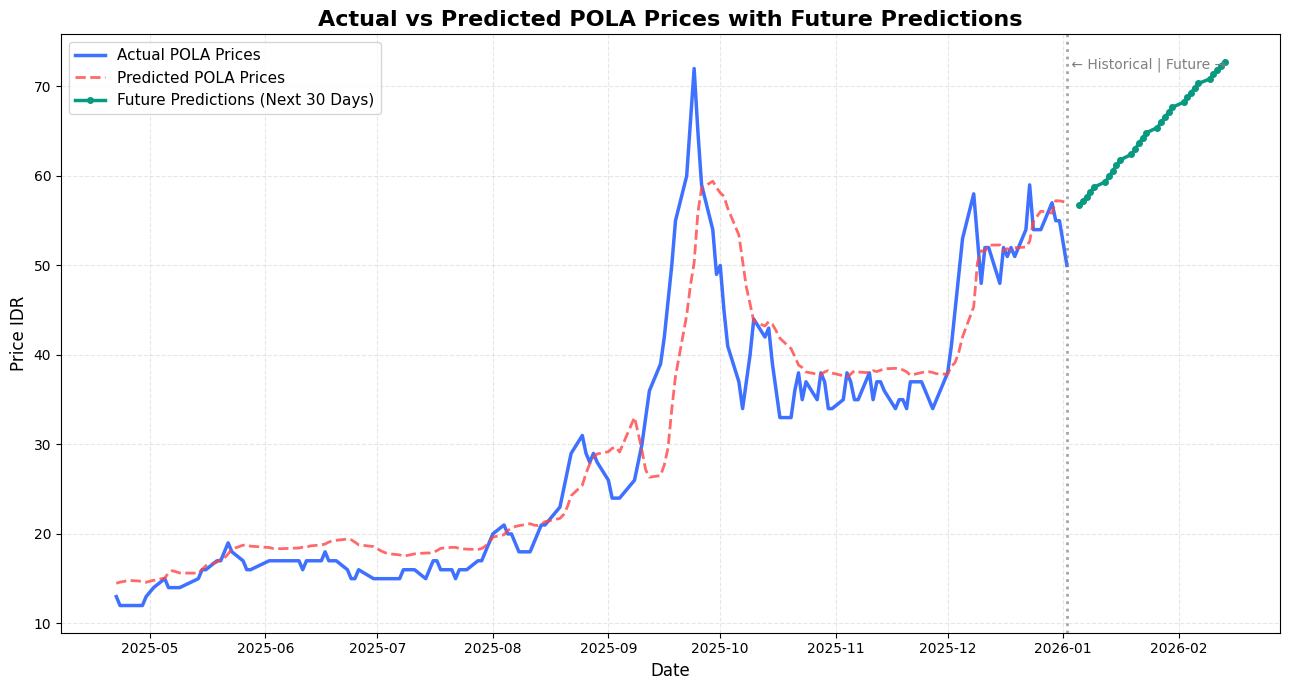

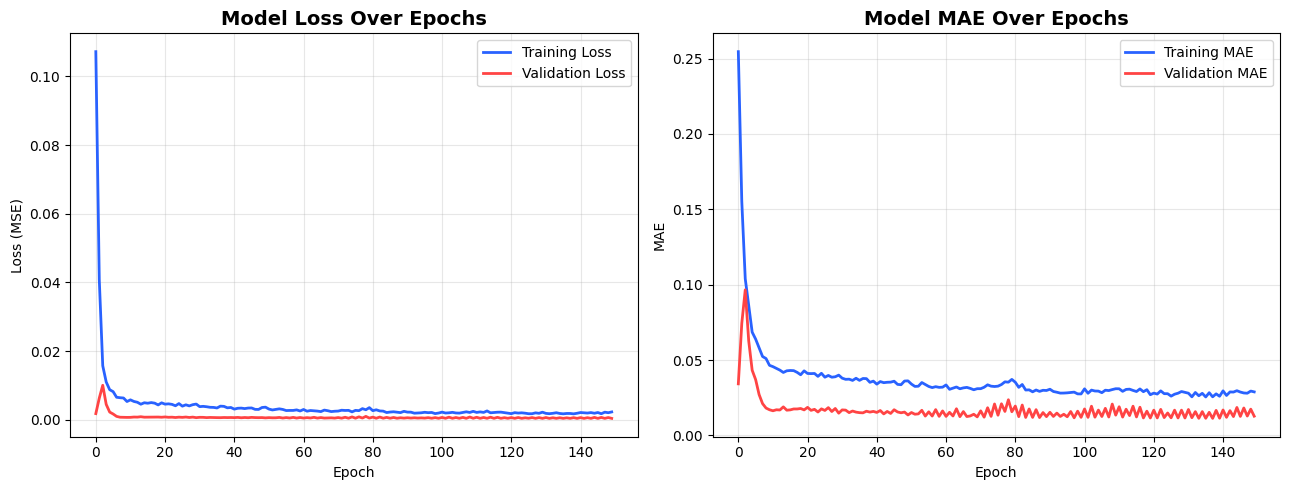

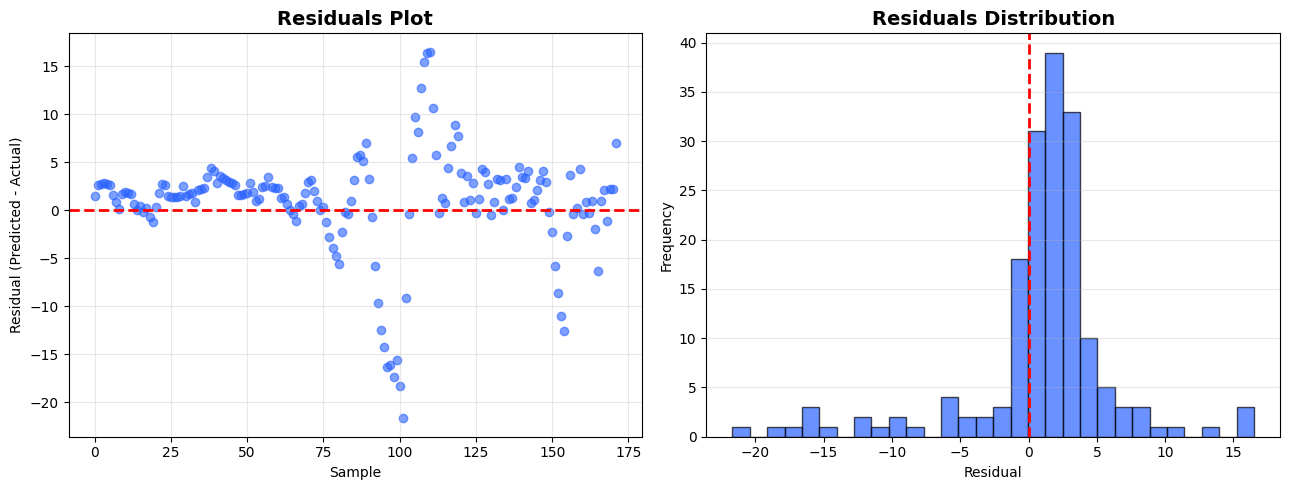

📊 Residual Statistics:
   Mean Residual: 0.8706 (should be close to 0)
   Std Residual:  5.4607


In [96]:
plt.figure(figsize=(13, 7))

# Hitung index yang tepat untuk test data
# Index test dimulai dari: train_size + sequence_length
test_start_idx = len(df) - len(y_test_unscaled)
test_dates = df.index[test_start_idx:]

# Plot actual vs predicted
plt.plot(test_dates, y_test_unscaled, 
         label='Actual POLA Prices', color='#2962ff', linewidth=2.5, alpha=0.9)
plt.plot(test_dates, predictions_unscaled, 
         label='Predicted POLA Prices', color='#ff4444', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(future_dates, future_predictions, 
         label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5, marker='o', markersize=4)

# Tambahkan garis vertikal untuk memisahkan historical dan future
plt.axvline(x=df.index[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2)
plt.text(df.index[-1], plt.ylim()[1]*0.95, ' ← Historical | Future →', 
         fontsize=10, color='gray')

plt.title('Actual vs Predicted POLA Prices with Future Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price IDR', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', color='#2962ff', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='#ff4444', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', color='#2962ff', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='#ff4444', linewidth=2)
axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot residuals untuk cek pola error
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
residuals = (predictions_unscaled - y_test_unscaled).flatten()
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='#2962ff')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.xlabel('Sample')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, color='#2962ff', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"📊 Residual Statistics:")
print(f"   Mean Residual: {np.mean(residuals):.4f} (should be close to 0)")
print(f"   Std Residual:  {np.std(residuals):.4f}")

In [92]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price POLA': future_predictions
})

future_predictions_df.head(15)

,Date,Predicted Price POLA
0,2026-01-05,56.752163
1,2026-01-06,57.189346
2,2026-01-07,57.665573
3,2026-01-08,58.189766
4,2026-01-09,58.749893
5,2026-01-12,59.335732
6,2026-01-13,59.938805
7,2026-01-14,60.552551
8,2026-01-15,61.170204
9,2026-01-16,61.790745


In [93]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price POLA'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: profit 45.57%
